<a href="https://colab.research.google.com/github/MehaRima/2sxc-content-app/blob/master/Copy_of_qlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Q-learning

This notebook will guide you through implementation of vanilla Q-learning algorithm.

You need to implement QLearningAgent (follow instructions for each method) and use it on a number of tests below.

In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/spring20/setup_colab.sh -O- | bash

    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/grading.py -O ../grading.py
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/week3_model_free/submit.py

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Selecting previously unselected package xvfb.
(Reading database ... 144556 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.4_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.4) ...
Setting up xvfb (2:1.19.6-1ubuntu4.4) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Starting virtual X frame buffer: Xvfb.


In [2]:
!pip install matplotlib-venn
!apt-get -qq install -y libfluidsynth1
# To determine which version you're using:
!pip show tensorflow

# For the current version: 
!pip install --upgrade tensorflow

# For a specific version:
!pip install tensorflow==1.2

# For the latest nightly build:
!pip install tf-nightly
# https://pypi.python.org/pypi/libarchive
!apt-get -qq install -y libarchive-dev && pip install -U libarchive
import libarchive
!apt-get -qq install python-cartopy python3-cartopy
import cartopy
# https://pypi.python.org/pypi/pydot
!apt-get -qq install -y graphviz && pip install pydot
import pydot

Selecting previously unselected package libfluidsynth1:amd64.
(Reading database ... 144563 files and directories currently installed.)
Preparing to unpack .../libfluidsynth1_1.1.9-1_amd64.deb ...
Unpacking libfluidsynth1:amd64 (1.1.9-1) ...
Setting up libfluidsynth1:amd64 (1.1.9-1) ...
Processing triggers for libc-bin (2.27-3ubuntu1) ...
/sbin/ldconfig.real: /usr/local/lib/python3.6/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

Name: tensorflow
Version: 2.3.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: grpcio, keras-preprocessing, opt-einsum, tensorboard, astunparse, protobuf, tensorflow-estimator, wheel, absl-py, scipy, termcolor, gast, six, h5py, numpy, google-pasta, wrapt
Required-by: fancyimpute
Requirement already up-to-date: tensorflow in /usr/local/lib

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
%%writefile qlearning.py
from collections import defaultdict
import random, math
import numpy as np

class QLearningAgent:
    def __init__(self, alpha, epsilon, discount, get_legal_actions):
        """
        Q-Learning Agent
        based on http://inst.eecs.berkeley.edu/~cs188/sp09/pacman.html
        Instance variables you have access to
          - self.epsilon (exploration prob)
          - self.alpha (learning rate)
          - self.discount (discount rate aka gamma)

        Functions you should use
          - self.get_legal_actions(state) {state, hashable -> list of actions, each is hashable}
            which returns legal actions for a state
          - self.get_qvalue(state,action)
            which returns Q(state,action)
          - self.set_qvalue(state,action,value)
            which sets Q(state,action) := value

        !!!Important!!!
        Note: please avoid using self._qValues directly. 
            There's a special self.get_qvalue/set_qvalue for that.
        """

        self.get_legal_actions = get_legal_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount

    def get_qvalue(self, state, action):
        """ Returns Q(state,action) """
        return self._qvalues[state][action]

    def set_qvalue(self,state,action,value):
        """ Sets the Qvalue for [state,action] to the given value """
        self._qvalues[state][action] = value

    #---------------------START OF YOUR CODE---------------------#

    def get_value(self, state):
        """
        Compute your agent's estimate of V(s) using current q-values
        V(s) = max_over_action Q(state,action) over possible actions.
        Note: please take into account that q-values can be negative.
        """
        possible_actions = self.get_legal_actions(state)

        #If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0
        value = max(self.get_qvalue(state, action) for action in possible_actions)
        return value

    def update(self, state, action, reward, next_state):
        """
        You should do your Q-Value update here:
           Q(s,a) := (1 - alpha) * Q(s,a) + alpha * (r + gamma * V(s'))
        """

        #agent parameters
        gamma = self.discount
        learning_rate = self.alpha

        q_value = ((1 - learning_rate) * self.get_qvalue(state, action) + 
                   learning_rate * (reward + gamma * self.get_value(next_state)))
        
        self.set_qvalue(state, action, q_value)

    
    def get_best_action(self, state):
        """
        Compute the best action to take in a state (using current q-values). 
        """
        possible_actions = self.get_legal_actions(state)

        #If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        max_value = -float('inf')
        best_action = None
        for action in possible_actions:
            value = self.get_qvalue(state, action)
            if value > max_value:
                max_value = value
                best_action = action

        return best_action

    def get_action(self, state):
        """
        Compute the action to take in the current state, including exploration.  
        With probability self.epsilon, we should take a random action.
            otherwise - the best policy action (self.getPolicy).
        
        Note: To pick randomly from a list, use random.choice(list). 
              To pick True or False with a given probablity, generate uniform number in [0, 1]
              and compare it with your probability
        """

        # Pick Action
        possible_actions = self.get_legal_actions(state)
        action = None

        #If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        if random.uniform(0, 1) < self.epsilon:
            chosen_action = random.choice(possible_actions)
        else:
            chosen_action = self.get_best_action(state)
        
        return chosen_action

Writing qlearning.py


### Try it on taxi

Here we use the qlearning agent on taxi env from openai gym.
You will need to insert a few agent functions here.

In [5]:
import gym

try:
    env = gym.make('Taxi-v3')
except gym.error.DeprecatedEnv:
    # Taxi-v2 was replaced with Taxi-v3 in gym 0.15.0
    env = gym.make('Taxi-v2')

n_actions = env.action_space.n

In [7]:

from qlearning import QLearningAgent

agent = QLearningAgent(alpha=0.5, epsilon=0.25, discount=0.99,
                       get_legal_actions = lambda s: range(n_actions))

In [8]:
def play_and_train(env,agent,t_max=10**4):
    """
    This function should 
    - run a full game, actions given by agent's e-greedy policy
    - train agent using agent.update(...) whenever it is possible
    - return total reward
    """
    total_reward = 0.0
    s = env.reset()
    
    for t in range(t_max):
        # get agent to pick action given state s.
        # <YOUR CODE HERE>
        a = agent.get_action(s)
        
        next_s, r, done, _ = env.step(a)
        
        # train (update) agent for state s
        # <YOUR CODE HERE>
        agent.update(s, a, r, next_s)
        
        s = next_s
        total_reward +=r
        if done: break
        
    return total_reward

In [9]:
def play_and_train(env,agent,t_max=10**4):
    """
    This function should 
    - run a full game, actions given by agent's e-greedy policy
    - train agent using agent.update(...) whenever it is possible
    - return total reward
    """
    total_reward = 0.0
    s = env.reset()
    
    for t in range(t_max):
        # get agent to pick action given state s.
        # <YOUR CODE HERE>
        a = agent.get_action(s)
        
        next_s, r, done, _ = env.step(a)
        
        # train (update) agent for state s
        # <YOUR CODE HERE>
        agent.update(s, a, r, next_s)
        
        s = next_s
        total_reward +=r
        if done: break
        
    return total_reward

eps = 2.9191091959171894e-05 mean reward = 7.2


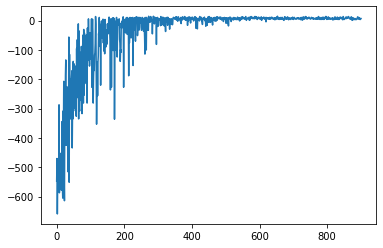

In [10]:
from IPython.display import clear_output

rewards = []
for i in range(1000):
    rewards.append(play_and_train(env, agent))
    agent.epsilon *= 0.99

    if i % 100 == 0:
        clear_output(True)
        print('eps =', agent.epsilon, 'mean reward =', np.mean(rewards[-10:]))
        plt.plot(rewards)
        plt.show()
        

### Submit to Coursera I: Preparation

In [11]:
submit_rewards1 = rewards.copy()

# Binarized state spaces

Use agent to train efficiently on `CartPole-v0`.
This environment has a continuous set of possible states, so you will have to group them into bins somehow.

The simplest way is to use `round(x,n_digits)` (or `np.round`) to round a real number to a given amount of digits.

The tricky part is to get the `n_digits` right for each state to train effectively.

Note that you don't need to convert state to integers, but to __tuples__ of any kind of values.

first state:[-0.02444165  0.03955105 -0.04352528 -0.0002555 ]


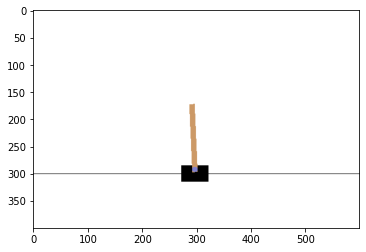

In [12]:
env = gym.make("CartPole-v0")
n_actions = env.action_space.n

print("first state:%s" % (env.reset()))
plt.imshow(env.render('rgb_array'))

### Play a few games

We need to estimate observation distributions. To do so, we'll play a few games and record all states.

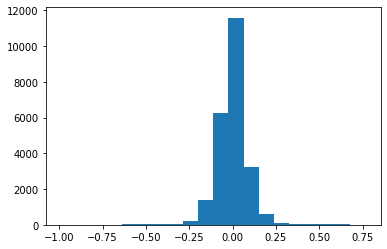

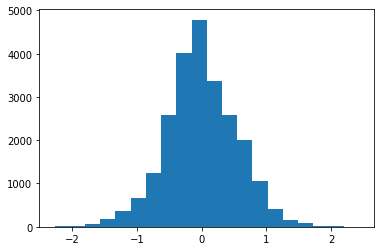

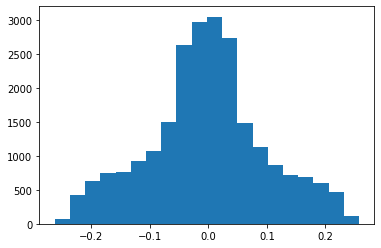

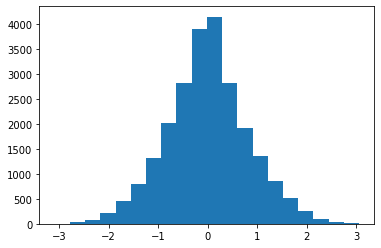

In [17]:
all_states = []
for _ in range(1000):
    all_states.append(env.reset())
    agent.epsilon *= 0.99
    done = False
    while not done:
        s, r, done, _ = env.step(env.action_space.sample()) 
        all_states.append(s)
        if done:
            break

all_states = np.array(all_states)

for obs_i in range(env.observation_space.shape[0]):
    plt.hist(all_states[:, obs_i], bins=20)
    plt.show()

## Binarize environment

In [18]:
from gym.core import ObservationWrapper
class Binarizer(ObservationWrapper):
    
    # def _observation(self, state):
    def observation(self, state):
        
        #state = <round state to some amount digits.>
        #hint: you can do that with round(x,n_digits)
        #you will need to pick a different n_digits for each dimension
        
        precision_increase = 0 # 0 or -1
        
        state = (round(state[0], 2 + precision_increase), # or 1 ?
                 round(state[1], 1 + precision_increase), # or 0 ?
                 round(state[2], 2 + precision_increase), # or 1 ?
                 round(state[3], 1 + precision_increase), # or 0 ? 
                )
        
        return tuple(state)

In [19]:
env = Binarizer(gym.make("CartPole-v0").env)

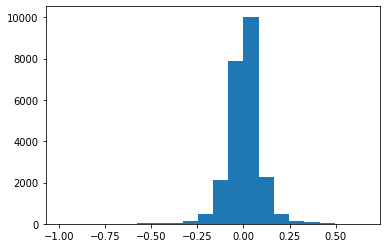

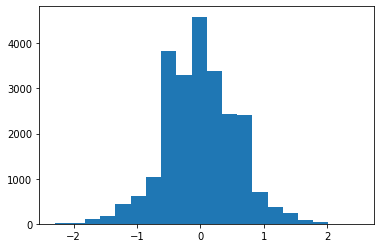

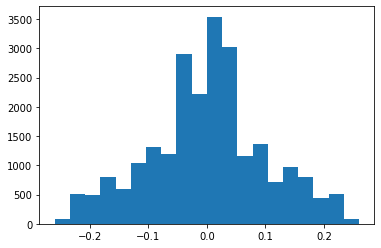

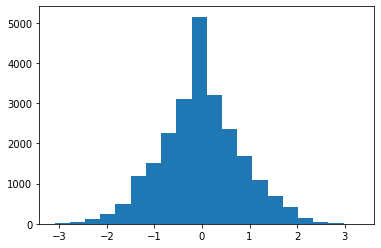

In [20]:
all_states = []
for _ in range(1000):
    all_states.append(env.reset())
    done = False
    while not done:
        s, r, done, _ = env.step(env.action_space.sample())
        all_states.append(s)
        if done:
            break

all_states = np.array(all_states)

for obs_i in range(env.observation_space.shape[0]):

    plt.hist(all_states[:, obs_i], bins=20)
    plt.show()

## Learn binarized policy

Now let's train a policy that uses binarized state space.

__Tips:__
* If your binarization is too coarse, your agent may fail to find optimal policy. In that case, change binarization. 
* If your binarization is too fine-grained, your agent will take much longer than 1000 steps to converge. You can either increase number of iterations and decrease epsilon decay or change binarization.
* Having $10^3$–$10^4$ distinct states is recommended (`len(QLearningAgent._qvalues)`), but not required.
* A reasonable agent should get to an average reward of at least 50.

In [21]:
agent = QLearningAgent(alpha=0.5, epsilon=0.25, discount=0.99,
                       get_legal_actions=lambda s: range(n_actions))

eps = 0.059 mean reward = 151.4


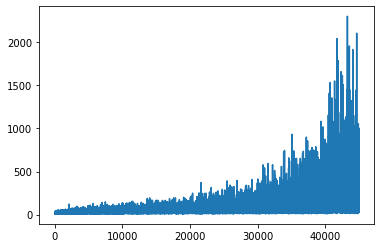

In [22]:
rewards = []
n_iter = 50000
for i in range(n_iter):
    rewards.append(play_and_train(env,agent))   
    
    # agent.epsilon = 0.25
    
    eps_start = 0.50
    eps_end = 0.01
    
    #OPTIONAL YOUR CODE: adjust epsilon
    if i % int(n_iter/10) == 0:
        agent.epsilon = eps_start + (i/n_iter) * (-eps_start + eps_end)
        clear_output(True)
        print('eps =', agent.epsilon, 'mean reward =', np.mean(rewards[-10:]))
        plt.plot(rewards)
        plt.show()

### Submit to Coursera II: Submission

In [23]:
submit_rewards2 = rewards.copy()

In [24]:
from submit import submit_qlearning
submit_qlearning(submit_rewards1, submit_rewards2, 'sahelirima23@gmail.com', '70qTFnqpn8PBzLaK')

Submitted to Coursera platform. See results on assignment page!
